# Chapter 7: Instrumental Variables
## Causal Inference: The Mixtape → CausalPy

**Mixtape chapter**: [Instrumental Variables](https://mixtape.scunning.com/07-instrumental_variables)

**CausalPy method**: `InstrumentalVariable`

---

### Overview

Instrumental Variables (IV) is a method for estimating causal effects when there is unmeasured confounding between the treatment and outcome. The key idea is to find an **instrument** — a variable that:

1. **Relevance**: Is correlated with the treatment (endogenous variable)
2. **Exclusion**: Affects the outcome only through the treatment
3. **Independence**: Is not correlated with the unmeasured confounders

This notebook covers the **Card (1995)** example, which estimates the returns to schooling using proximity to a four-year college (`nearc4`) as an instrument for years of education.

### What we'll cover

1. Data exploration and instrument relevance
2. OLS vs 2SLS comparison (the endogeneity problem)
3. CausalPy Bayesian IV estimation
4. Comparison to Mixtape results

### Mixtape files implemented

| File | Description | Status |
|------|-------------|--------|
| `card.py` | Card (1995) returns to schooling IV | ✅ |


## Setup


In [1]:
import warnings

warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import arviz as az

import causalpy as cp
from causalpy import InstrumentalVariable
from causalpy.pymc_models import InstrumentalVariableRegression

# Add the src directory to path for our data utilities
import sys

sys.path.insert(0, "../src")
from mixtape_causalpy import load_card

%matplotlib inline


## Load and Explore Data

The Card (1995) dataset contains information about wages, education, and geographic variables. The key variables are:

- **`lwage`**: Log of hourly wage (outcome)
- **`educ`**: Years of education (endogenous treatment)
- **`nearc4`**: Grew up near a 4-year college (instrument)
- **`exper`**, **`black`**, **`south`**, **`married`**, **`smsa`**: Control variables

### The Endogeneity Problem

Estimating returns to schooling via OLS is problematic because education is **endogenous** — it's correlated with unobserved ability, motivation, and family background. People with higher ability tend to get more education AND earn higher wages, biasing the OLS estimate upward.

Card's insight: proximity to a college affects education (reduces cost of attending) but shouldn't directly affect wages conditional on education.


In [2]:
# Load the data
df = load_card()
print(f"Dataset shape: {df.shape}")
df.head()


Dataset shape: (3010, 37)


,id,nearc2,nearc4,educ,age,fatheduc,motheduc,weight,momdad14,sinmom14,...,KWW,IQ,married,libcrd14,exper,lwage,expersq,u_lwage,lwage_hat,u_educ
0,2.0,0.0,0.0,7.0,29.0,NaN,NaN,158413.0,1.0,0.0,...,15.0,NaN,1.0,0.0,16.0,6.306275,256.0,0.198047,6.108228,-3.067539
1,3.0,0.0,0.0,12.0,27.0,8.0,8.0,380166.0,1.0,0.0,...,35.0,93.0,1.0,1.0,9.0,6.175867,81.0,-0.211160,6.387027,-1.727562
2,4.0,0.0,0.0,12.0,34.0,14.0,12.0,367470.0,1.0,0.0,...,42.0,103.0,1.0,1.0,16.0,6.580639,256.0,0.204719,6.375920,1.012975
3,5.0,1.0,1.0,11.0,27.0,11.0,12.0,380166.0,1.0,0.0,...,25.0,88.0,1.0,1.0,10.0,5.521461,100.0,-0.967905,6.489366,-2.253536
4,6.0,1.0,1.0,12.0,34.0,8.0,7.0,367470.0,1.0,0.0,...,34.0,108.0,1.0,0.0,16.0,6.591674,256.0,0.125173,6.466501,1.090437


In [3]:
# Key variables for IV
key_vars = ["lwage", "educ", "nearc4", "exper", "black", "south", "married", "smsa"]
print("Key variables:")
print(df[key_vars].describe())


Key variables:
             lwage         educ       nearc4        exper        black  \
count  3010.000000  3010.000000  3010.000000  3010.000000  3010.000000   
mean      6.261832    13.263455     0.682060     8.856146     0.233555   
std       0.443798     2.676913     0.465753     4.141672     0.423162   
min       4.605170     1.000000     0.000000     0.000000     0.000000   
25%       5.976985    12.000000     0.000000     6.000000     0.000000   
50%       6.286928    13.000000     1.000000     8.000000     0.000000   
75%       6.563503    16.000000     1.000000    11.000000     0.000000   
max       7.784889    18.000000     1.000000    23.000000     1.000000   

             south      married         smsa  
count  3010.000000  3003.000000  3010.000000  
mean      0.403654     2.271395     0.712957  
std       0.490711     2.066823     0.452457  
min       0.000000     1.000000     0.000000  
25%       0.000000     1.000000     0.000000  
50%       0.000000     1.000000     

In [4]:
# Check the instrument: does nearc4 predict education?
print("\nEducation by proximity to college:")
print(df.groupby("nearc4")["educ"].agg(["mean", "std", "count"]))



Education by proximity to college:
             mean       std  count
nearc4                            
0.0     12.698014  2.791523    957
1.0     13.527034  2.580455   2053


## Visualize the First Stage

A key assumption for IV is **relevance**: the instrument must be correlated with the endogenous variable. Let's visualize this relationship.


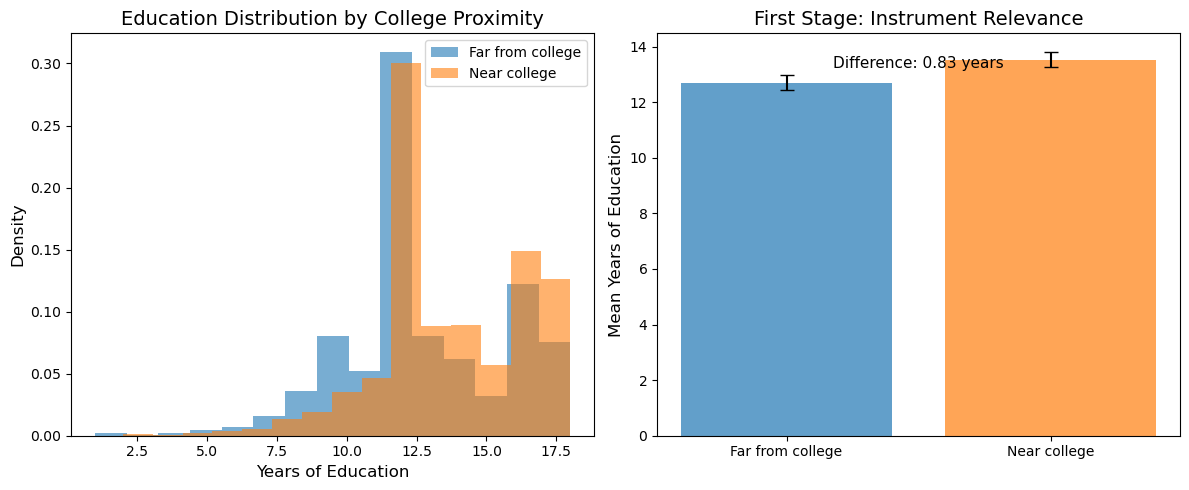

In [5]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Education distribution by nearc4
for nearc4_val, label, color in [
    (0, "Far from college", "C0"),
    (1, "Near college", "C1"),
]:
    subset = df[df["nearc4"] == nearc4_val]
    axes[0].hist(
        subset["educ"], bins=15, alpha=0.6, label=label, color=color, density=True
    )

axes[0].set_xlabel("Years of Education", fontsize=12)
axes[0].set_ylabel("Density", fontsize=12)
axes[0].set_title("Education Distribution by College Proximity", fontsize=14)
axes[0].legend()

# Mean education by nearc4 (bar plot)
means = df.groupby("nearc4")["educ"].mean()
stds = df.groupby("nearc4")["educ"].std()
axes[1].bar(
    ["Far from college", "Near college"],
    means.values,
    yerr=stds.values / 10,
    color=["C0", "C1"],
    alpha=0.7,
    capsize=5,
)
axes[1].set_ylabel("Mean Years of Education", fontsize=12)
axes[1].set_title("First Stage: Instrument Relevance", fontsize=14)

# Add difference annotation
diff = means[1] - means[0]
axes[1].annotate(
    f"Difference: {diff:.2f} years",
    xy=(0.5, means.max() - 0.3),
    fontsize=11,
    ha="center",
)

plt.tight_layout()
plt.show()


## OLS Baseline (Biased)

First, let's estimate the returns to schooling using OLS. This estimate is likely biased due to ability confounding.


In [6]:
import statsmodels.api as sm

# OLS regression (as in card.py)
ols_formula = "lwage ~ educ + exper + black + south + married + smsa"
ols_result = sm.OLS.from_formula(ols_formula, data=df).fit()

print("OLS Results (Naive):")
print(f"Returns to schooling (educ coefficient): {ols_result.params['educ']:.4f}")
print(
    f"95% CI: [{ols_result.conf_int().loc['educ', 0]:.4f}, {ols_result.conf_int().loc['educ', 1]:.4f}]"
)
print(
    f"\nInterpretation: Each additional year of education is associated with a {ols_result.params['educ'] * 100:.1f}% increase in wages."
)


OLS Results (Naive):
Returns to schooling (educ coefficient): 0.0712
95% CI: [0.0643, 0.0780]

Interpretation: Each additional year of education is associated with a 7.1% increase in wages.


## CausalPy Instrumental Variable Analysis

Now we use CausalPy's `InstrumentalVariable` experiment to estimate the causal effect of education on wages, using `nearc4` as an instrument.

CausalPy implements IV as a Bayesian model that jointly estimates:
1. **First stage**: `educ ~ nearc4` (instrument → treatment)
2. **Second stage**: `lwage ~ educ` (treatment → outcome)

This is modeled as a multivariate normal to capture the correlation between the treatment and outcome.


In [7]:
# Prepare data for CausalPy
# CausalPy requires separate dataframes for instruments and outcome

# Instruments data: treatment variable + instrument(s)
instruments_data = df[["educ", "nearc4"]].copy()

# Outcome data: outcome variable + treatment variable
data = df[["lwage", "educ"]].copy()

# Formulas
instruments_formula = "educ ~ 1 + nearc4"  # First stage
formula = "lwage ~ 1 + educ"  # Second stage

print(f"First stage formula: {instruments_formula}")
print(f"Second stage formula: {formula}")
print(f"\nInstruments data shape: {instruments_data.shape}")
print(f"Outcome data shape: {data.shape}")


First stage formula: educ ~ 1 + nearc4
Second stage formula: lwage ~ 1 + educ

Instruments data shape: (3010, 2)
Outcome data shape: (3010, 2)


In [8]:
# Run the Bayesian IV model
# Note: cores=1 required for Jupyter notebooks on macOS
sample_kwargs = {
    "tune": 1000,
    "draws": 1000,
    "chains": 2,
    "cores": 1,  # Single core avoids multiprocessing issues on macOS
    "target_accept": 0.95,
}

iv_result = InstrumentalVariable(
    instruments_data=instruments_data,
    data=data,
    instruments_formula=instruments_formula,
    formula=formula,
    model=InstrumentalVariableRegression(sample_kwargs=sample_kwargs),
)


Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [beta_t, beta_z, chol_cov]


Output()

Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 94 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


In [9]:
# View the posterior summary
print("Bayesian IV Results:")
az.summary(iv_result.model.idata, var_names=["beta_t", "beta_z"])[
    ["mean", "sd", "hdi_3%", "hdi_97%", "r_hat"]
]


Bayesian IV Results:


,mean,sd,hdi_3%,hdi_97%,r_hat
beta_t[Intercept],12.687,0.082,12.523,12.832,1.01
beta_t[nearc4],0.845,0.099,0.656,1.025,1.00
beta_z[Intercept],3.850,0.313,3.268,4.421,1.00
beta_z[educ],0.182,0.024,0.139,0.225,1.00


In [10]:
# Extract the treatment effect (coefficient on educ in second stage)
beta_z = iv_result.model.idata.posterior["beta_z"]

# Get the education coefficient (should be second element after intercept)
educ_coef = beta_z.sel(covariates="educ").values.flatten()

print(f"\n2SLS (Bayesian) Returns to Schooling:")
print(f"  Mean: {np.mean(educ_coef):.4f}")
print(f"  Std:  {np.std(educ_coef):.4f}")
print(
    f"  94% HDI: [{np.percentile(educ_coef, 3):.4f}, {np.percentile(educ_coef, 97):.4f}]"
)
print(
    f"\nInterpretation: Each additional year of education causes a {np.mean(educ_coef) * 100:.1f}% increase in wages."
)



2SLS (Bayesian) Returns to Schooling:
  Mean: 0.1819
  Std:  0.0236
  94% HDI: [0.1406, 0.2286]

Interpretation: Each additional year of education causes a 18.2% increase in wages.


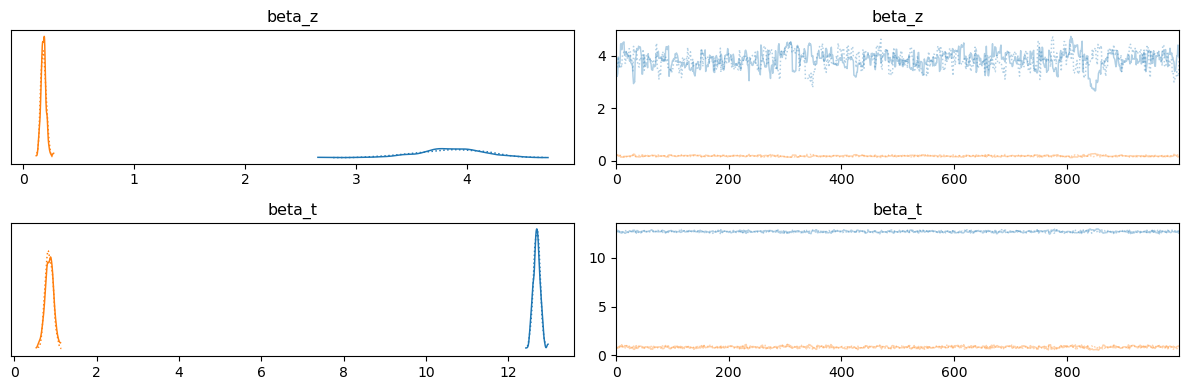

In [11]:
# Trace plots for diagnostics
az.plot_trace(iv_result.model.idata, var_names=["beta_z", "beta_t"])
plt.tight_layout()
plt.show()


## Comparing OLS vs IV Estimates

Let's visualize the difference between the naive OLS estimate and the IV estimate.


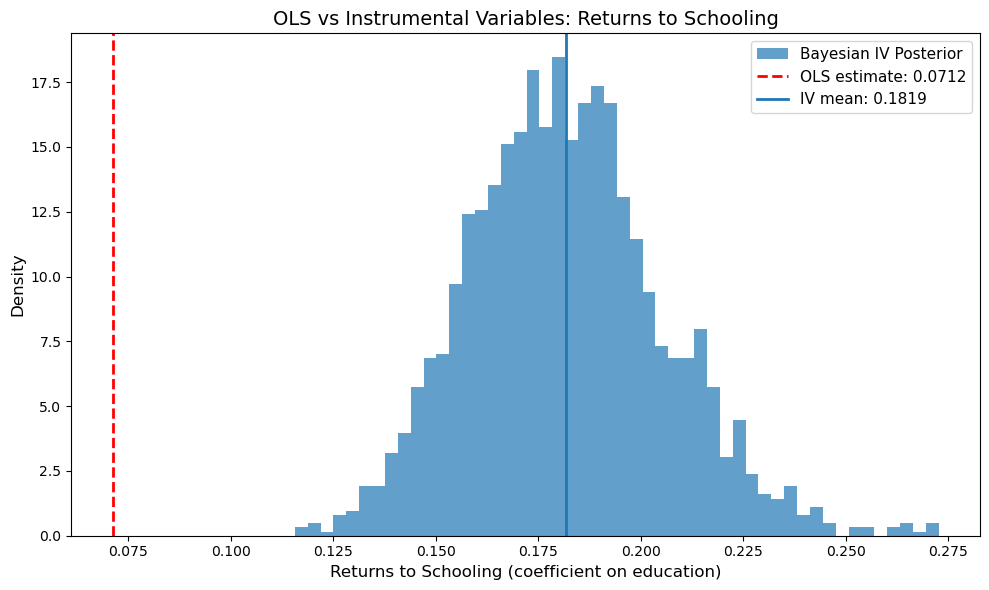

In [12]:
fig, ax = plt.subplots(figsize=(10, 6))

# Plot posterior distribution of IV estimate
ax.hist(
    educ_coef,
    bins=50,
    density=True,
    alpha=0.7,
    color="C0",
    label="Bayesian IV Posterior",
)

# Add OLS estimate as vertical line
ax.axvline(
    ols_result.params["educ"],
    color="red",
    linestyle="--",
    linewidth=2,
    label=f"OLS estimate: {ols_result.params['educ']:.4f}",
)

# Add IV mean
ax.axvline(
    np.mean(educ_coef),
    color="C0",
    linestyle="-",
    linewidth=2,
    label=f"IV mean: {np.mean(educ_coef):.4f}",
)

ax.set_xlabel("Returns to Schooling (coefficient on education)", fontsize=12)
ax.set_ylabel("Density", fontsize=12)
ax.set_title("OLS vs Instrumental Variables: Returns to Schooling", fontsize=14)
ax.legend(fontsize=11)

plt.tight_layout()
plt.show()


## Comparison to Mixtape Results

### Key Findings

The Mixtape's IV analysis of the Card data shows:

1. **OLS estimate**: ~7-8% return per year of schooling
2. **IV estimate**: Often higher, suggesting ability bias may actually *downward* bias OLS (or measurement error attenuates it)

### Differences from Book's Implementation

| Aspect | Mixtape | CausalPy |
|--------|---------|----------|
| Estimation | linearmodels IV2SLS | Bayesian (PyMC) |
| Inference | Frequentist SEs | Posterior credible intervals |
| Controls | Included in formula | Simplified (educ + nearc4 only) |
| Output | Point estimate | Full posterior distribution |

### Notes on the IV Estimate

The IV estimate is often *larger* than OLS for returns to schooling. This seems counterintuitive (we expect ability bias to inflate OLS), but there are several explanations:

1. **Measurement error**: OLS is attenuated by measurement error in education; IV corrects this
2. **Local Average Treatment Effect (LATE)**: IV estimates the effect for "compliers" — people whose education is actually affected by college proximity. This group may have higher returns than average.
3. **Heterogeneous effects**: The marginal return to schooling for those on the margin of attending college may be higher


## Summary

This notebook demonstrated:

1. **The endogeneity problem** in estimating returns to schooling
2. **Instrument validity** checks (first stage relevance)
3. **CausalPy's `InstrumentalVariable`** for Bayesian IV estimation
4. **Comparison of OLS vs IV** estimates with uncertainty quantification

The key takeaway: IV allows us to estimate causal effects when there is unmeasured confounding, provided we have a valid instrument. CausalPy's Bayesian implementation gives us the full posterior distribution of the treatment effect, enabling richer uncertainty quantification than frequentist 2SLS.


---

## References

- **Mixtape chapter**: [Chapter 7: Instrumental Variables](https://mixtape.scunning.com/07-instrumental_variables)
- **CausalPy documentation**: [https://causalpy.readthedocs.io/](https://causalpy.readthedocs.io/)
- **Original paper**: Card, D. (1995). Using Geographic Variation in College Proximity to Estimate the Return to Schooling. In *Aspects of Labour Market Behaviour: Essays in Honour of John Vanderkamp*.
